In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from scipy import integrate, optimize
from scipy.stats import norm, multivariate_normal

In [2]:
# observable parameters
T = 1.0                                            # time to maturity
S0 = 150                                           # spot price
K = 150                                            # stike price
r = 0.05                                           # risk-free rate

# unobservable parameters
mu = 0.10                                          # drift
rho = 0.30                                         # correlation coefficient
v0 = 0.4**2                                        # spot variance
theta = 0.45**2                                    # long-term variance
kappa = 5.0                                        # mean reversion coefficient
sigma = 0.3                                        # volatility of instantaneous variance (Vol of Vol)

# simulation parameters
paths = 5                                          # number of paths
steps = 100000                                     # number of time steps

## Heston Model
The Heston model is a mathematical model used to describe the dynamics of stock prices with stochastic volatility. It is defined by the following system of stochastic differential equations (SDEs):

$$ \begin{cases}
dS_t = \mu S_t dt + \sqrt{v_t} S_t dW^1_t \\
dv_t = \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW^2_t\\
dW^1_tdW^2_t = \rho dt
\end{cases}$$

In this model, the stock price follows a geometric Brownian motion with a stochastic volatility. The square of the volatility, also known as the variance, follows a Cox-Ingersoll-Ross (CIR) process.

The model's parameters are as follows:

- $\mu$: Drift of the stock process
- $\kappa$: Mean reversion coefficient of the variance process
- $\theta$: Long-term mean of the variance process
- $\sigma$: Volatility coefficient of the variance process
- $\rho$: Correlation between the Wiener processes $W^1_t$ and $W^2_t$

The Feller condition, expressed as $2\kappa\theta \ge \sigma^2$, guarantees that the process $v_t$ is almost surely bounded from below by zero. However, in numerical implementations, it is necessary to take a large number of time steps to prevent the occurrence of negative variance samples.

## Monte Carlo Simulation


The Monte Carlo simulation method used for the Heston model is generally considered to be less efficient in terms of both space and speed compared to the numerical computation of the semi-closed form solution derived from Fourier inversion theory. It is important to acknowledge that, despite satisfying the Feller condition, there is still a possibility of encountering negative variances in certain samples due to inherent imperfections in numerical methods. One potential approach to mitigate this issue is to increase the number of time steps, although this would require additional computational resources and storage space. Alternatively, the problem of negative variance can be addressed by imposing a lower bound for the variance, which has been implemented here.

In [3]:
# Feller condition
assert(2*kappa * theta > sigma**2)

# Generate random 2D Brownian motions
W = multivariate_normal.rvs( mean = np.array([0, 0]),
                             cov = np.array([[1, rho], [rho, 1]]),
                             size = (paths, steps-1) )

# Initialize vectors
S = np.zeros((paths,steps)); S[:,0] = S0
v = np.zeros((paths,steps)); v[:,0] = v0

# Compute the corresponding paths
T_vec, dt = np.linspace(0, T, steps, retstep=True)
for t in range(0,steps-1):
    S[:,t+1] = S[:,t] + mu * S[:,t] * dt + S[:,t] * ( v[:,t] * dt )**0.5 * W[:,t,0]
    v[:,t+1] = v[:,t] + kappa * ( theta - v[:,t] ) * dt + sigma * ( v[:,t] * dt )**0.5 * W[:,t,1]
    v[v[:,t+1] < 0.0, t+1] = 1e-5 # prevent negative variance

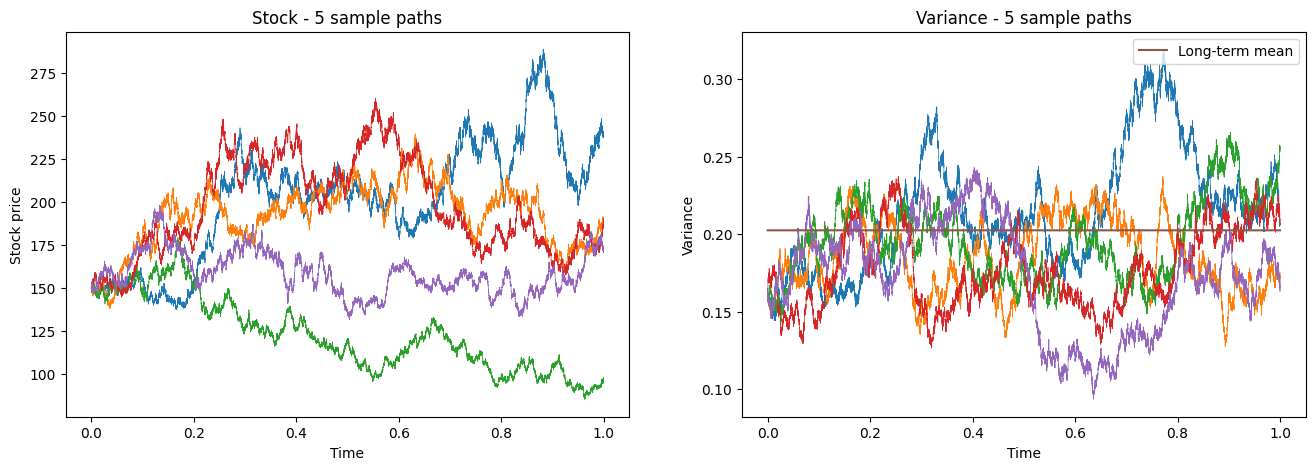

In [4]:
# Visualize the sample paths

fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(121)
ax1.plot(T_vec, S.T, linewidth = 0.5)
ax1.set_title(f'Stock - {paths} sample paths')
ax1.set_xlabel('Time')
ax1.set_ylabel('Stock price')

ax2 = fig.add_subplot(122)
ax2.plot(T_vec, v.T, linewidth = 0.5)
ax2.plot(T_vec, theta*np.ones_like(T_vec), label='Long-term mean' )
ax2.set_title(f'Variance - {paths} sample paths')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')
ax2.legend(loc='upper right')

plt.show()

In [5]:
# Encapsulate the above Monte Carlo simulation
def sample_paths(T, S0, mu, rho, v0, theta, kappa, sigma, paths, steps):

    """
    Generate stock and variance sample paths in the Heston model
    """

    # Feller condition
    assert(2*kappa * theta > sigma**2)

    # Generate random 2D Brownian motions
    W = multivariate_normal.rvs( mean = np.array([0, 0]),
                                cov = np.array([[1, rho], [rho, 1]]),
                                size = (paths, steps-1) )

    # Initialize vectors
    S = np.zeros((paths,steps)); S[:,0] = S0
    v = np.zeros((paths,steps)); v[:,0] = v0

    # Compute the corresponding paths
    T_vec, dt = np.linspace(0, T, steps, retstep=True)
    for t in range(0,steps-1):
        S[:,t+1] = S[:,t] + mu * S[:,t] * dt + S[:,t] * ( v[:,t] * dt )**0.5 * W[:,t,0]
        v[:,t+1] = v[:,t] + kappa * ( theta - v[:,t] ) * dt + sigma * ( v[:,t] * dt )**0.5 * W[:,t,1]
        v[v[:,t+1] < 0.0, t+1] = 1e-5 # prevent negative variance

    return S, v

## Semi-closed Form Solution to Vanilla Option

\begin{align*}
& C = S_0Q_1 - Ke^{-rT}Q_2\\
& P = Ke^{-rT}(1-Q_2) - S_0(1-Q_1)\\\\
& \textit{where } X = log(\frac{S_T}{S_0})\textit{, } k = log(\frac{K}{S_0})\textit{, } \phi_X(u) = E^{\mathbb{Q}}[e^{iuX}]\\
& Q_1 = \frac{1}{2} + \frac{1}{\pi} \int_0^{\infty} Re\biggl[ \frac{ e^{-iuk} \phi_X(u-i)}{iu \, \phi_X(-i)} \biggr] du \\
& Q_2 =\frac{1}{2} + \frac{1}{\pi} \int_0^{\infty} Re\biggl[ \frac{ e^{-iuk} \phi_X(u)}{iu} \biggr] du\\
\end{align*}

In [6]:
def cf(u, T, mu, rho, v0, theta, kappa, sigma):

    """
    Heston characteristic function in Schoutens (2004)
    """

    d = ((kappa - rho*sigma*u*1j)**2 + sigma**2*(1j*u + u**2))**0.5
    g = (kappa - rho*sigma*u*1j - d)/(kappa - rho*sigma*u*1j + d)
    cf_ = np.exp( 1j*u*mu*T +\
                 theta*kappa*sigma**-2*((kappa - rho*sigma*u*1j - d)*T - 2*np.log((1 - g*np.exp(-d*T))/( 1 - g))) +\
                 v0*sigma**-2*(kappa - rho*sigma*u*1j - d)*(1 - np.exp(-d*T))/(1 - g*np.exp(-d*T)) )
    return cf_


def fourier_inversion(T, S0, K, r, mu, rho, v0, theta, kappa, sigma, option_type):
    k = np.log(K/S0)
    cf_ = partial(cf, T = T, mu = mu, rho = rho, v0 = v0, theta = theta, kappa = kappa, sigma = sigma )

    integrand_Q1 = lambda u: np.real((np.exp(-u*k*1j) * cf_(u-1j) / (u*1j)) / cf_(-1j))
    integrand_Q2 = lambda u: np.real(np.exp(-u*k*1j) * cf_(u) / (u*1j))

    Q1 = 1/2 + 1/np.pi * integrate.quad(integrand_Q1, 1e-15, np.inf, limit=2000)[0]
    Q2 = 1/2 + 1/np.pi * integrate.quad(integrand_Q2, 1e-15, np.inf, limit=2000)[0]

    if option_type == 'call':
        return S0 * Q1 - K * np.exp(-r*T) * Q2
    elif option_type == 'put':
        return K * np.exp(-r*T) * (1-Q2) - S0 * (1-Q1)


## Option Pricing - MC and Semi-closed Solution
As illustrated below, the implementation of the semi-closed form solution exhibits clear advantages over the Monte Carlo simulation, excelling in terms of both speed and storage space.

In [7]:
# simulation parameters
paths = 100000                                     # number of paths
steps = int(T*252*4)                               # number of time steps

In [8]:
%%time
S, _ = sample_paths(T = T, S0 = S0, mu = r, rho = rho, v0 = v0,
                   theta = theta, kappa = kappa, sigma = sigma, paths = paths, steps = steps) # RN drift = r
C = np.exp(-r*T) * np.maximum(S[:,-1]-K,0)

print(f'Monte Carlo call price: {C.mean():.4f} with standard error {C.std()/paths**0.5:.4f}')

S = [] # clear memory

Monte Carlo call price: 29.2634 with standard error 0.1722
CPU times: user 47.8 s, sys: 4.2 s, total: 52 s
Wall time: 57.1 s


In [9]:
%%time
C = fourier_inversion(T = T, S0 = S0, K = K, r = r, mu = r, rho = rho,
                  v0 = v0, theta = theta, kappa = kappa, sigma = sigma, option_type = 'call')

print(f'Semi-closed form solution call price: {C}:.4f')

Semi-closed form solution call price: 29.330807817183853:.4f
CPU times: user 10.2 ms, sys: 21 µs, total: 10.3 ms
Wall time: 10.3 ms


## Sensitivity Analysis of Implied Volatility Smile

In some cases, numerical root finders may fail to calculate the implied volatility due to insensitivity of far in-the-money or out-the-money options to the volatility input. To overcome this challenge, one can employ multiple numerical methods and combine their results, or compute the implied volatility for both call and put options and ensure continuity in merging the answers (put-call parity).

The sensitivity analysis of the Heston model reveals the following effects on each parameter:

- $\rho$: Rotates the curve.
- $v_0$ and $\theta$: Causes a parallel shift of the curve.
- $\kappa$ and $\sigma$: Alters the curvature of the curve.

In [10]:
arr_K = np.linspace(50, 450, 100)

def black_scholes(S, K, r, T, v0_sqrt, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * v0_sqrt ** 2) * T) / (v0_sqrt * np.sqrt(T))
    d2 = d1 - v0_sqrt * np.sqrt(T)
    Q1 = norm.cdf(d1)
    Q2 = norm.cdf(d2)

    if option_type == 'call':
        option_price = S * Q1 - K * np.exp(-r * T) * Q2
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * (1-Q2) - S * (1-Q1)

    return option_price


def implied_volatility(list_P, S, arr_K, r, T, option_type):
    list_implied_vol = []

    for P, K in zip(list_P, arr_K):
        difference = lambda x: black_scholes(S, K, r, T, x, option_type) - P
        list_implied_vol.append( optimize.fsolve(difference, x0 = 0.3)[0] )

    return list_implied_vol

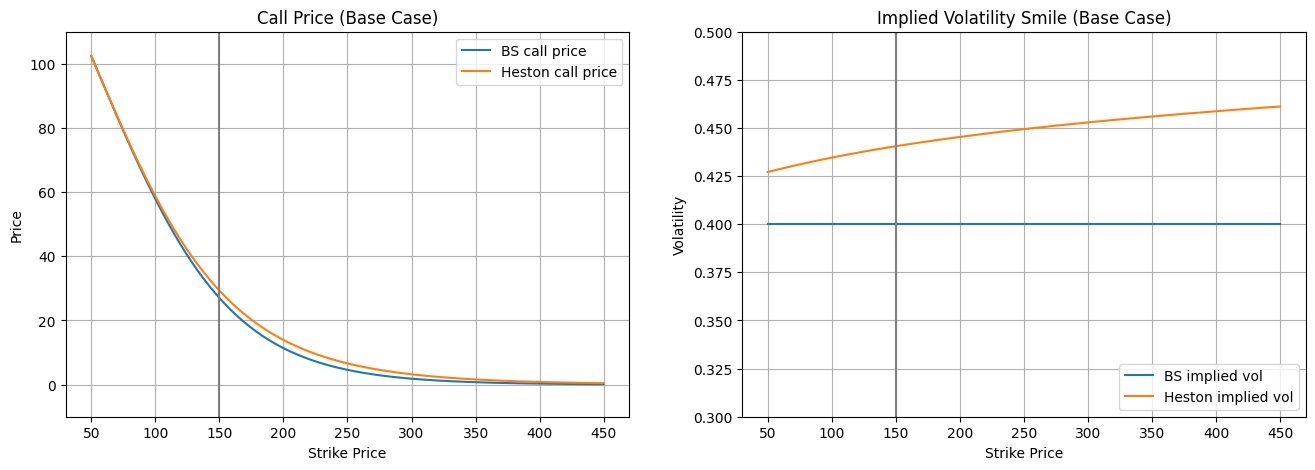

In [11]:
# Base case

list_P_BS = []
list_P_Heston = []

for K_ in arr_K:
    list_P_BS.append( black_scholes(S0, K_, r, T, v0**0.5, 'call') )
    list_P_Heston.append( fourier_inversion(T = T, S0 = S0, K = K_, r = r, mu = r, rho = rho,
                            v0 = v0, theta = theta, kappa = kappa, sigma = sigma, option_type = 'call') )
list_implied_vol_BS = implied_volatility(list_P_BS, S0, arr_K, r, T, 'call')
list_implied_vol_Heston = implied_volatility(list_P_Heston, S0, arr_K, r, T, 'call')


# Plot the call price and implied volatility smile
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(121)
ax1.plot(arr_K, list_P_BS, label='BS call price')
ax1.plot(arr_K, list_P_Heston, label='Heston call price')
ax1.axvline(x = S0, color = 'grey')
ax1.set_ylim([-10, 110])
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Price')
ax1.set_title('Call Price (Base Case)')
ax1.legend(loc='upper right')
ax1.grid(True)

ax2 = fig.add_subplot(122)
ax2.plot(arr_K, list_implied_vol_BS, label='BS implied vol')
ax2.plot(arr_K, list_implied_vol_Heston, label='Heston implied vol')
ax2.axvline(x = S0, color = 'grey')
ax2.set_ylim([0.3, 0.5])
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Volatility')
ax2.set_title('Implied Volatility Smile (Base Case)')
ax2.legend(loc='lower right')
ax2.grid(True)

plt.show()

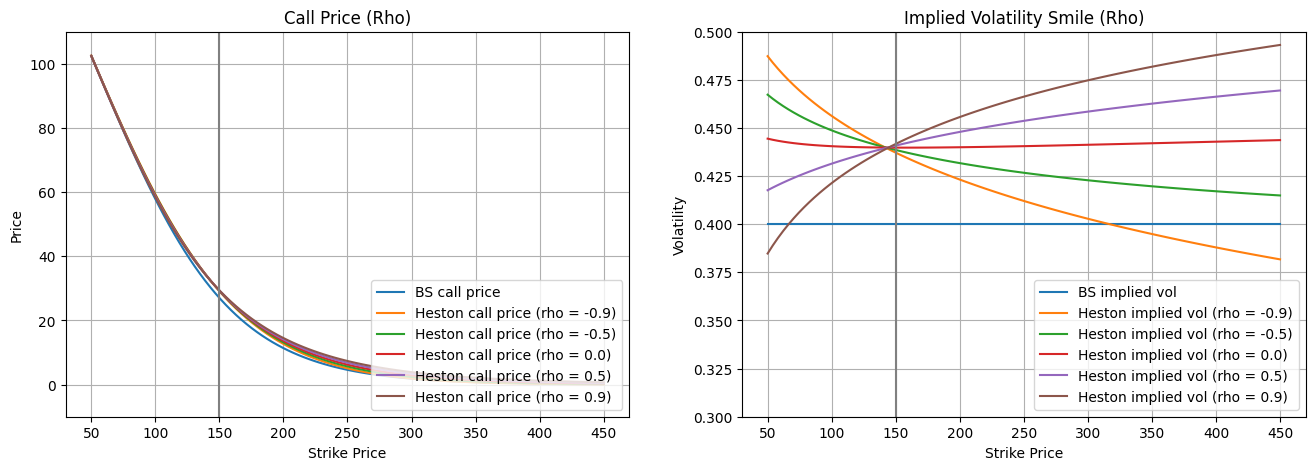

In [12]:
# Rho - correlation coefficient

fig = plt.figure(figsize=(16,5))
array_rho = np.linspace(-0.9, 0.9, 5)

# BS call price and implied vol
ax1 = fig.add_subplot(121); ax1.plot(arr_K, list_P_BS, label='BS call price')
ax2 = fig.add_subplot(122); ax2.plot(arr_K, list_implied_vol_BS, label='BS implied vol')


# Heston call price and implied vol
for rho_ in array_rho:
  list_P_Heston = []
  for K_ in arr_K:
      list_P_Heston.append( fourier_inversion(T = T, S0 = S0, K = K_, r = r, mu = r, rho = rho_,
                            v0 = v0, theta = theta, kappa = kappa, sigma = sigma, option_type = 'call') )
  list_implied_vol_Heston = implied_volatility(list_P_Heston, S0, arr_K, r, T, 'call')

  ax1.plot(arr_K, list_P_Heston, label=f'Heston call price (rho = {rho_:.1f})')
  ax2.plot(arr_K, list_implied_vol_Heston, label=f'Heston implied vol (rho = {rho_:.1f})')

ax1.axvline(x = S0, color = 'grey')
ax1.set_ylim([-10, 110])
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Price')
ax1.set_title('Call Price (Rho)')
ax1.legend(loc='lower right')
ax1.grid(True)

ax2.axvline(x = S0, color = 'grey')
ax2.set_ylim([0.3, 0.5])
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Volatility')
ax2.set_title('Implied Volatility Smile (Rho)')
ax2.legend(loc='lower right')
ax2.grid(True)

plt.show()

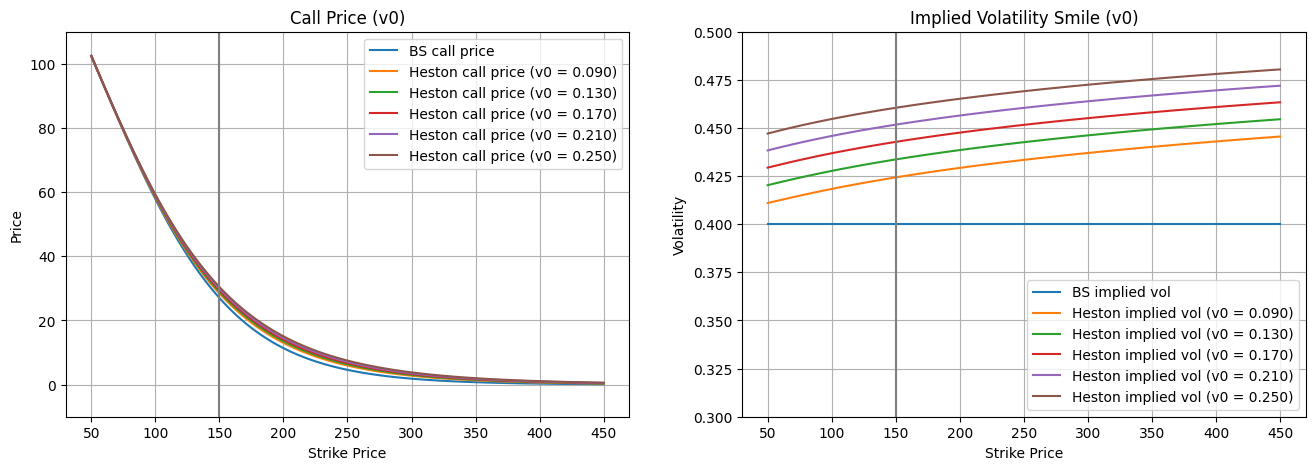

In [13]:
# v0 - spot variance

fig = plt.figure(figsize=(16,5))
array_v0 = np.linspace(0.3**2, 0.5**2, 5)

# BS call price and implied vol
ax1 = fig.add_subplot(121); ax1.plot(arr_K, list_P_BS, label='BS call price')
ax2 = fig.add_subplot(122); ax2.plot(arr_K, list_implied_vol_BS, label='BS implied vol')


# Heston call price and implied vol
for v0_ in array_v0:
  list_P_Heston = []
  for K_ in arr_K:
      list_P_Heston.append( fourier_inversion(T = T, S0 = S0, K = K_, r = r, mu = r, rho = rho,
                            v0 = v0_, theta = theta, kappa = kappa, sigma = sigma, option_type = 'call') )
  list_implied_vol_Heston = implied_volatility(list_P_Heston, S0, arr_K, r, T, 'call')

  ax1.plot(arr_K, list_P_Heston, label=f'Heston call price (v0 = {v0_:.3f})')
  ax2.plot(arr_K, list_implied_vol_Heston, label=f'Heston implied vol (v0 = {v0_:.3f})')

ax1.axvline(x = S0, color = 'grey')
ax1.set_ylim([-10, 110])
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Price')
ax1.set_title('Call Price (v0)')
ax1.legend(loc='upper right')
ax1.grid(True)

ax2.axvline(x = S0, color = 'grey')
ax2.set_ylim([0.3, 0.5])
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Volatility')
ax2.set_title('Implied Volatility Smile (v0)')
ax2.legend(loc='lower right')
ax2.grid(True)

plt.show()

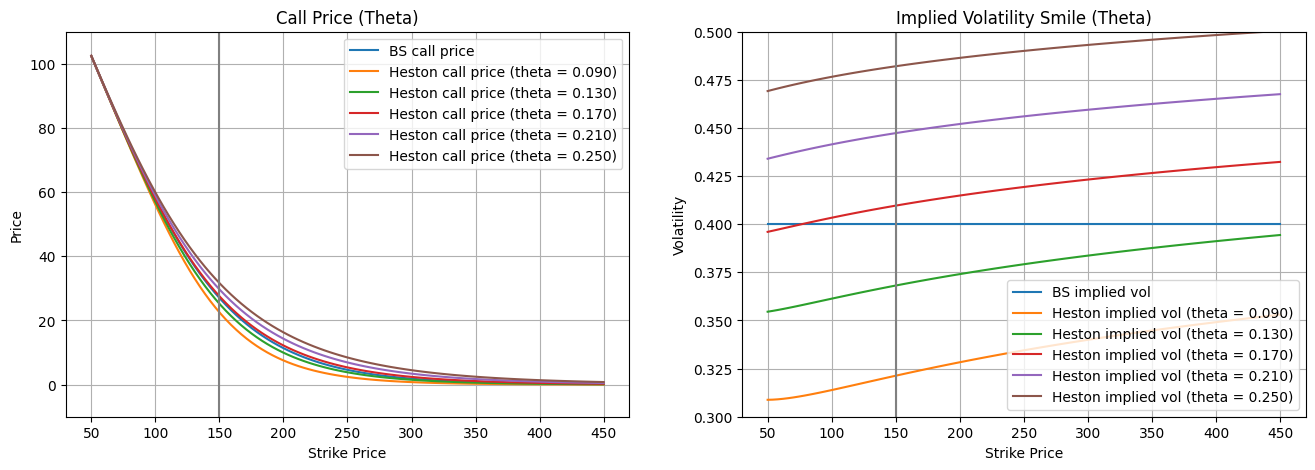

In [14]:
# Theta - long-term variance

fig = plt.figure(figsize=(16,5))
array_theta = np.linspace(0.3**2, 0.5**2, 5)

# BS call price and implied vol
ax1 = fig.add_subplot(121); ax1.plot(arr_K, list_P_BS, label='BS call price')
ax2 = fig.add_subplot(122); ax2.plot(arr_K, list_implied_vol_BS, label='BS implied vol')


# Heston call price and implied vol
for theta_ in array_theta:
  list_P_Heston = []
  for K_ in arr_K:
      list_P_Heston.append( fourier_inversion(T = T, S0 = S0, K = K_, r = r, mu = r, rho = rho,
                            v0 = v0, theta = theta_, kappa = kappa, sigma = sigma, option_type = 'call') )
  list_implied_vol_Heston = implied_volatility(list_P_Heston, S0, arr_K, r, T, 'call')

  ax1.plot(arr_K, list_P_Heston, label=f'Heston call price (theta = {theta_:.3f})')
  ax2.plot(arr_K, list_implied_vol_Heston, label=f'Heston implied vol (theta = {theta_:.3f})')

ax1.axvline(x = S0, color = 'grey')
ax1.set_ylim([-10, 110])
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Price')
ax1.set_title('Call Price (Theta)')
ax1.legend(loc='upper right')
ax1.grid(True)

ax2.axvline(x = S0, color = 'grey')
ax2.set_ylim([0.3, 0.5])
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Volatility')
ax2.set_title('Implied Volatility Smile (Theta)')
ax2.legend(loc='lower right')
ax2.grid(True)

plt.show()

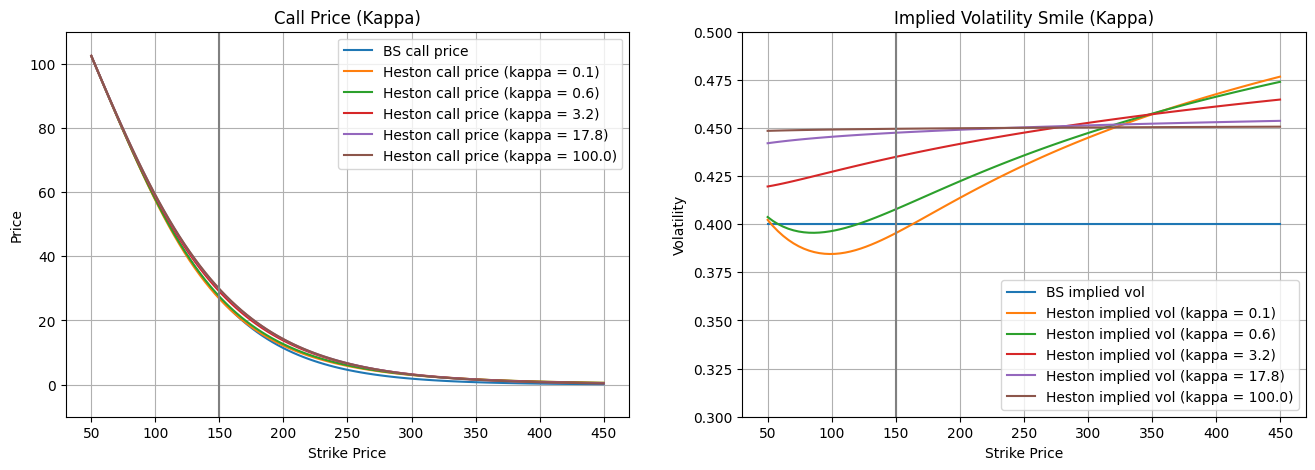

In [15]:
# Kappa - mean reversion coefficient

fig = plt.figure(figsize=(16,5))
array_kappa = np.geomspace(0.1, 100, 5)

# BS call price and implied vol
ax1 = fig.add_subplot(121); ax1.plot(arr_K, list_P_BS, label='BS call price')
ax2 = fig.add_subplot(122); ax2.plot(arr_K, list_implied_vol_BS, label='BS implied vol')


# Heston call price and implied vol
for kappa_ in array_kappa:
  list_P_Heston = []
  for K_ in arr_K:
      list_P_Heston.append( fourier_inversion(T = T, S0 = S0, K = K_, r = r, mu = r, rho = rho,
                            v0 = v0, theta = theta, kappa = kappa_, sigma = sigma, option_type = 'call') )
  list_implied_vol_Heston = implied_volatility(list_P_Heston, S0, arr_K, r, T, 'call')

  ax1.plot(arr_K, list_P_Heston, label=f'Heston call price (kappa = {kappa_:.1f})')
  ax2.plot(arr_K, list_implied_vol_Heston, label=f'Heston implied vol (kappa = {kappa_:.1f})')

ax1.axvline(x = S0, color = 'grey')
ax1.set_ylim([-10, 110])
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Price')
ax1.set_title('Call Price (Kappa)')
ax1.legend(loc='upper right')
ax1.grid(True)

ax2.axvline(x = S0, color = 'grey')
ax2.set_ylim([0.3, 0.5])
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Volatility')
ax2.set_title('Implied Volatility Smile (Kappa)')
ax2.legend(loc='lower right')
ax2.grid(True)

plt.show()

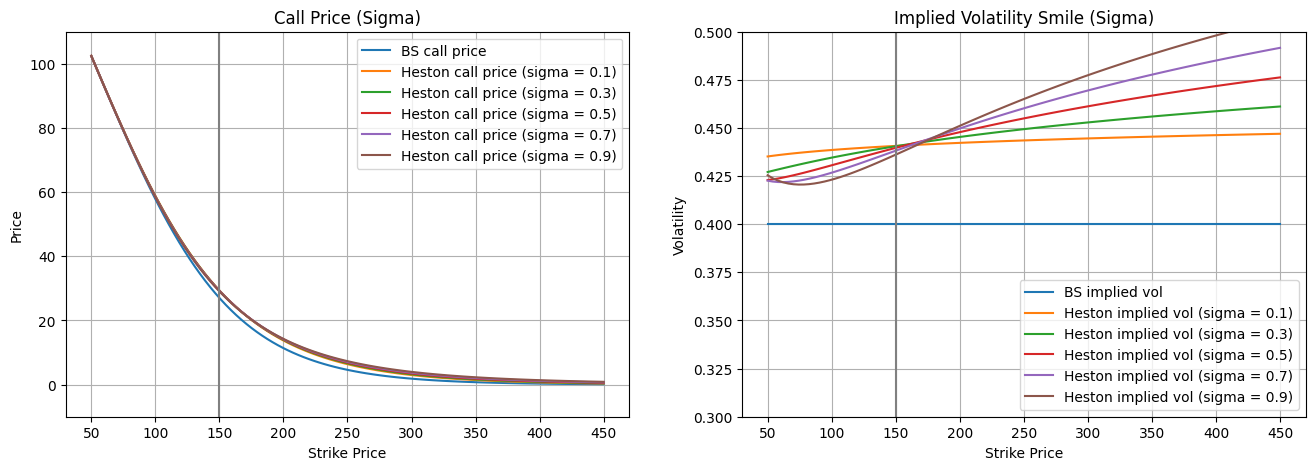

In [16]:
# Sigma - volatility of instantaneous variance (Vol of Vol)

fig = plt.figure(figsize=(16,5))
array_sigma = np.linspace(0.1, 0.9, 5)

# BS call price and implied vol
ax1 = fig.add_subplot(121); ax1.plot(arr_K, list_P_BS, label='BS call price')
ax2 = fig.add_subplot(122); ax2.plot(arr_K, list_implied_vol_BS, label='BS implied vol')


# Heston call price and implied vol

for sigma_ in array_sigma:
  list_P_Heston = []
  for K_ in arr_K:
      list_P_Heston.append( fourier_inversion(T = T, S0 = S0, K = K_, r = r, mu = r, rho = rho,
                            v0 = v0, theta = theta, kappa = kappa, sigma = sigma_, option_type = 'call') )
  list_implied_vol_Heston = implied_volatility(list_P_Heston, S0, arr_K, r, T, 'call')

  ax1.plot(arr_K, list_P_Heston, label=f'Heston call price (sigma = {sigma_:.1f})')
  ax2.plot(arr_K, list_implied_vol_Heston, label=f'Heston implied vol (sigma = {sigma_:.1f})')

ax1.axvline(x = S0, color = 'grey')
ax1.set_ylim([-10, 110])
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Price')
ax1.set_title('Call Price (Sigma)')
ax1.legend(loc='upper right')
ax1.grid(True)

ax2.axvline(x = S0, color = 'grey')
ax2.set_ylim([0.3, 0.5])
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Volatility')
ax2.set_title('Implied Volatility Smile (Sigma)')
ax2.legend(loc='lower right')
ax2.grid(True)

plt.show()

## Technical Note - Gil Pelaez formula

\begin{align*}
  F_X(x) &= \frac{1}{2} - \frac{1}{2\pi} \int_{\mathbb{R}} e^{-iux} \phi_X(u) \cdot \frac{1}{iu} \, du \\
         &= \frac{1}{2} - \frac{1}{2\pi} \int_0^{\infty} \biggl(-e^{iux} \phi_X(-u) + e^{-iux} \phi_X(u) \biggr) \frac{1}{iu} \, du \\
         &= \frac{1}{2} - \frac{1}{\pi} \int_0^{\infty} \frac{Im[ e^{-iux} \phi_X(u) ]}{u} du \\
         &= \frac{1}{2} - \frac{1}{\pi} \int_0^{\infty} Re\biggl[ \frac{ e^{-iux} \phi_X(u)}{iu} \biggr] du \\
  f_X(x) &= \frac{1}{\pi} \int_0^{\infty} Re\biggl[ e^{-iux} \phi_X(u) \biggr] du
\end{align*}